# Generate Synthetic Images


In [22]:
import numpy as np
from skimage.draw import disk, ellipse, rectangle
from skimage.io import imshow, imsave
import random
import math

def check_overlap(center1, center2, distance):
    return np.sqrt(np.sum((np.array(center1) - np.array(center2)) ** 2)) < distance


def ellipse_perimeter(a, b):
    """
    Calculate the perimeter of an ellipse using Ramanujan's approximation.
    
    Parameters:
    - a: Semi-major axis of the ellipse
    - b: Semi-minor axis of the ellipse
    
    Returns:
    - The approximate perimeter of the ellipse
    """
    return math.pi * (3*(a + b) - math.sqrt((3*a + b) * (a + 3*b)))


def generate_shapes(circle_radius=50, ellipse_width=100, ratio=0.5,overlap_distance=None,square_side=100, path=None, seed=None):

    if seed is not None:
        random.seed(seed) 

    img = np.zeros((2048, 2048), dtype=np.uint16)  # Create a black 16-bit grayscale image
    ground_truth = [] 

    # Generate 1 circle
    center = [random.randint(circle_radius, 2048-circle_radius), random.randint(circle_radius, 2048-circle_radius)]  # Randomly specify center
    rr, cc = disk(center, circle_radius)
    img[rr, cc] = 65535
    ground_truth.append({'Area': math.pi * circle_radius ** 2,'Centroid_Y': center[0],'Centroid_X': center[1],'Perimeter': 2 * math.pi * circle_radius})  

    # Generate 1 ellipse with specified eccentricity
    height = ellipse_width * ratio
    center_ellipse = [random.randint(ellipse_width//2, 2048-ellipse_width//2), random.randint(height//2, 2048-height//2)]  # Randomly specify center
    while check_overlap(center, center_ellipse, circle_radius + max(ellipse_width//2, height//2)):  # Ensure the ellipse does not overlap with the circle
        center_ellipse = [random.randint(ellipse_width//2, 2048-ellipse_width//2), random.randint(height//2, 2048-height//2)]
    rr, cc = ellipse(center_ellipse[0], center_ellipse[1], ellipse_width//2, height//2)
    img[rr, cc] = 65535
    ground_truth.append({ 'Area': math.pi * (ellipse_width//2) * (height//2),'Centroid_Y': center_ellipse[0],'Centroid_X': center_ellipse[1],'Perimeter':ellipse_perimeter(ellipse_width//2,height//2)})  

    # Generate 1 square
    start = (random.randint(0, 2048-square_side), random.randint(0, 2048-square_side))  # Randomly specify start
    while check_overlap(center, start, circle_radius + square_side) or check_overlap(center_ellipse, start, max(ellipse_width//2, height//2) + square_side):  # Ensure the square does not overlap with the circle or the ellipse
        start = (random.randint(0, 2048-square_side), random.randint(0, 2048-square_side))
    rr, cc = rectangle(start, extent=(square_side, square_side))
    img[rr, cc] = 65535
    ground_truth.append({'Area': square_side**2,'Centroid_Y':(start[0]+square_side//2),'Centroid_X':(start[1]+square_side//2),'Perimeter':square_side*4})  # Add to ground truth
    
    # Add 2 overlapping circles

    if overlap_distance == None:
        overlap_distance = circle_radius // 2 
         
    center1 = np.array([random.randint(circle_radius, 2048-circle_radius-2*overlap_distance), random.randint(circle_radius, 2048-circle_radius-2*overlap_distance)])
    center2 = center1 + np.array([overlap_distance, overlap_distance])  # Calculate the center of the second circle based on the overlap distance
    while check_overlap(center, center1, 2 * circle_radius) or check_overlap(center_ellipse, center1, max(ellipse_width//2, height//2) + circle_radius) or check_overlap(center, center2, 2 * circle_radius) or check_overlap(center_ellipse, center2, max(ellipse_width//2, height//2) + circle_radius) or check_overlap(start, center1, square_side + circle_radius) or check_overlap(start, center2, square_side + circle_radius):  # Ensure the overlapping circles do not overlap with the single circle, the ellipse, or the square
        center1 = np.array([random.randint(circle_radius, 2048-circle_radius), random.randint(circle_radius, 2048-circle_radius)])
        center2 = center1 + np.array([overlap_distance, overlap_distance])
    rr, cc = disk(center1, circle_radius)
    img[rr, cc] = 65535
    rr, cc = disk(center2, circle_radius)
    img[rr, cc] = 65535
#######
    # Calculate the perimeter of each circle
    perimeter_each_circle = 2 * math.pi * circle_radius

    # Calculate the arc length in radians
    arc_length_rad = 2 * math.acos((circle_radius - overlap_distance) / circle_radius)

    # Convert the arc length to length units
    arc_length = arc_length_rad * circle_radius

    # Calculate the total perimeter of the overlapping circles
    total_perimeter = 2 * perimeter_each_circle - 2 * arc_length
    
    # Calculate the area of each sector
    area_each_sector = (arc_length_rad / (2 * math.pi)) * math.pi * circle_radius**2

    area_each_triangle = (circle_radius**2 / 2) * math.sin(arc_length_rad)

    area_each_circle = math.pi * circle_radius**2

    area_overlap = 2 * area_each_sector - 2 * area_each_triangle

    # Calculate the total area of the two circles including the overlapping region
    total_area = 2 * area_each_circle - area_overlap
####
    # Centroid= [(center1 + center2) / 2]    
    # print('Centroid_X:',Centroid[0][0])
    ground_truth.append({'Area': total_area,'Centroid_Y': [(center1 + center2) / 2][0][0],'Centroid_X': [(center1 + center2) / 2][0][1],'Perimeter':total_perimeter})  # Add to ground truth
    # {'Area': total_area,'Centroid_X':(start[0]+square_side//2),'Centroid_Y':(start[1]+square_side//2),'Perimeter':square_side*4})
    imshow(img, cmap='gray')
    if path!=None:
        imsave(path, img)

    # Generate ground truth
    

    return img, ground_truth

# Generate synthetik image and analyze

In [2]:
%load_ext autoreload
%autoreload 2

import os
import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage.color import rgb2gray

import tifffile as TIFF
from matplotlib import cm
from skimage import measure
from skimage import io
import PyPlaque

from PyPlaque.utils import get_plaque_mask, PlaqueImageReadout

c:\Python311\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:162: UserWarning: The figure layout has changed to tight
  ax.get_figure().tight_layout()


            Area  Centroid_Y  Centroid_X    Perimeter
0   70685.834706       425.0      1315.0   942.477796
1   28274.333882      1885.0      1703.0   690.384369
2  160000.000000      1764.0       329.0  1600.000000
3  113733.351193       709.5       428.5  1256.637061
4   70685.834706      1888.0       265.0   942.477796


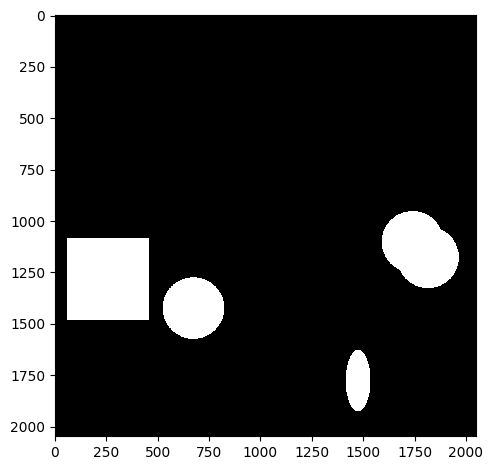

In [24]:
#Generate 5 images and ground truth
data=[]

for i in range(1, 6):
    img,gt = generate_shapes(circle_radius=150, ellipse_width=300, ratio=0.4, square_side=400,seed=i)
    filename = f"data\\A0{i}_w2.TIF"
    data.extend(gt) 
    imsave(filename, img)


# Convert the list of dictionaries to a DataFrame
    

df = pd.DataFrame(data)
print(df.head())
#order columns
df= df[['Area','Centroid_X','Centroid_Y','Perimeter']]
# Optionally, save the DataFrame to a CSV file
df.to_csv("gt_res.csv", index=False)

In [6]:
from importlib import reload
reload(PyPlaque)
image_bits = 16
virus_params = {
    'min_plaque_area': 2000,
    'virus_threshold': 0.032 * (2**image_bits - 1),
    #'virus_threshold': 0.03 * (2**image_bits - 1),
    'plaque_connectivity': 6,
    'fine_plaque_detection_flag': True,
    #'plaque_gaussian_filter_size': 150,
    'plaque_gaussian_filter_size': 200,
    'plaque_gaussian_filter_sigma': 100,
    'peak_region_size': 50,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 120
}

plate_dict_w2 = {}

# Initialize an empty DataFrame
output = []

# d = plate_dirs[0]

plate_name=  r'sample_plate'

i = 0
plate_dict_w2[plate_name] = {}
plate_dict_w2[plate_name]['img'] = {}
plate_dict_w2[plate_name]['mask'] = {}
plate_dict_w2[plate_name]['image_name'] = {}
image_files_for_comparison = glob.glob(r"E:\PLAQUE\PyPlaque\notebooks\synthetic_images\data\*.TIF")
print(image_files_for_comparison)
globalPeakCoords = []
for f in image_files_for_comparison:
    

    plate_dict_w2[plate_name]['img'][i] = TIFF.imread(f)
    plate_dict_w2[plate_name]['image_name'][i] = f
    img = plate_dict_w2[plate_name]['img'][i]
    plate_dict_w2[plate_name]['mask'][i],curPeakCoords = get_plaque_mask(img,virus_params)
    globalPeakCoords.append(curPeakCoords)
    im_name = plate_dict_w2[plate_name]['image_name'][i].split("\\")[-1]
    plq_image_readout = PlaqueImageReadout(nuclei_image_name=im_name,
                            plaque_image_name=im_name,
                            nuclei_image=np.array(plate_dict_w2[plate_name]['img'][i]),
                            plaque_image=np.array(plate_dict_w2[plate_name]['img'][i]),
                            nuclei_mask=np.array(plate_dict_w2[plate_name]['mask'][i]),
                            plaque_mask=np.array(plate_dict_w2[plate_name]['mask'][i]),
                            virus_params = virus_params)
    plq_objects = plq_image_readout.get_plaque_objects()
    for iPlaque in plq_objects:
        plq_object_readout = plq_image_readout.call_plaque_object_readout(iPlaque, virus_params)
        # Create a dictionary with the data
        data = {
            'Area': plq_object_readout.get_area(),
            'Centroid_X': plq_object_readout.get_centroid()[1],
            'Centroid_Y': plq_object_readout.get_centroid()[0],
            'Perimeter': plq_object_readout.get_perimeter(),
        }

        # Append the data to the DataFrame
        output.append(data)
    i += 1

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(output)

# Save the DataFrame to a CSV file
df.to_csv("pyplaque_res.csv", index=False)



['E:\\PLAQUE\\PyPlaque\\notebooks\\synthetic_images\\data\\A01_w2.TIF', 'E:\\PLAQUE\\PyPlaque\\notebooks\\synthetic_images\\data\\A02_w2.TIF', 'E:\\PLAQUE\\PyPlaque\\notebooks\\synthetic_images\\data\\A03_w2.TIF', 'E:\\PLAQUE\\PyPlaque\\notebooks\\synthetic_images\\data\\A04_w2.TIF', 'E:\\PLAQUE\\PyPlaque\\notebooks\\synthetic_images\\data\\A05_w2.TIF']


# Compare readouts

In [25]:
gt_df = pd.read_csv("gt_res.csv")
pyplaque_df = pd.read_csv("pyplaque_res.csv")
matlab_df = pd.read_csv("matlab_res.csv")
fiji_df = pd.read_csv("fiji_res.csv")   

gt_df = gt_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])
pyplaque_df = pyplaque_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])
matlab_df = matlab_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])
fiji_df = fiji_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])

average_gt_df = gt_df.groupby(gt_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])
average_pyplaque_df = pyplaque_df.groupby(pyplaque_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])
average_matlab_df = matlab_df.groupby(matlab_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])
average_fiji_df = fiji_df.groupby(fiji_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])

average_gt_df = average_gt_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])
average_pyplaque_df = average_pyplaque_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])
average_matlab_df = average_matlab_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])
average_fiji_df = average_fiji_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])

# average_gt_df = average_gt_df.sort_index()
# average_pyplaque_df = average_pyplaque_df.sort_index()
# average_matlab_df = average_matlab_df.sort_index()
# average_fiji_df = average_fiji_df.sort_index()




In [27]:
import pandas as pd

# Concatenate all dataframes into one
all_dfs = pd.concat([average_gt_df, average_pyplaque_df, average_matlab_df, average_fiji_df])

# Sort by 'Area'
all_dfs = all_dfs.sort_values(by='Area')

# Initialize 'Area_Group' with -1
all_dfs['Area_Group'] = -1

# Initialize the group number and the 'Area' of the previous row
group_num = 0
prev_area = all_dfs.iloc[0]['Area']

# Threshold for the difference in 'Area'
threshold = 10

# Iterate over the rows
for i in range(len(all_dfs)):
    # If the difference in 'Area' is less than the threshold, assign the same group number
    if abs(all_dfs.iloc[i]['Area'] - prev_area) < threshold:
        all_dfs.iloc[i]['Area_Group'] = group_num
    # If the difference in 'Area' is greater than or equal to the threshold, increment the group number and assign it
    else:
        group_num += 1
        all_dfs.iloc[i]['Area_Group'] = group_num

    # Update the 'Area' of the previous row
    prev_area = all_dfs.iloc[i]['Area']

print(average_gt_df)
print(average_pyplaque_df)
print(average_matlab_df)
print(average_fiji_df)

            Area    Perimeter
1   80193.570733  1035.976719
0   88675.870897  1086.395405
3   97285.374195  1149.227258
2  106538.703956  1217.899845
       Area    Perimeter
0   77786.6  1049.851457
2   89425.4  1125.246753
3   92501.2  1149.281731
1  100986.8  1203.005194
       Area  Perimeter
3   77786.6  1006.1696
1   84015.6  1049.4136
0   86272.2  1056.6784
2  112625.6  1232.1304
       Area  Perimeter
0   77786.6  1050.8054
2   89425.4  1126.5522
3   92501.2  1150.0014
1  100986.8  1203.7250


C:\Users\warda\AppData\Local\Temp\ipykernel_32132\82329152.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs.iloc[i]['Area_Group'] = group_num
C:\Users\warda\AppData\Local\Temp\ipykernel_32132\82329152.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs.iloc[i]['Area_Group'] = group_num


In [28]:
import pandas as pd

# Assuming the dataframes are already sorted by index
df = pd.concat([average_gt_df, average_pyplaque_df, average_matlab_df, average_fiji_df], axis=0, keys=['GT', 'pyplaque', 'matlab', 'fiji'])

# Reset the index and drop it
df = df.reset_index(drop=True)

print(df)

latex_table = df.to_latex(index=False)

print(latex_table)

                     Area    Perimeter
GT       1   80193.570733  1035.976719
         0   88675.870897  1086.395405
         3   97285.374195  1149.227258
         2  106538.703956  1217.899845
pyplaque 0   77786.600000  1049.851457
         2   89425.400000  1125.246753
         3   92501.200000  1149.281731
         1  100986.800000  1203.005194
matlab   3   77786.600000  1006.169600
         1   84015.600000  1049.413600
         0   86272.200000  1056.678400
         2  112625.600000  1232.130400
fiji     0   77786.600000  1050.805400
         2   89425.400000  1126.552200
         3   92501.200000  1150.001400
         1  100986.800000  1203.725000
\begin{tabular}{llrr}
\toprule
 &  & Area & Perimeter \\
\midrule
\multirow[t]{4}{*}{GT} & 1 & 80193.570733 & 1035.976719 \\
 & 0 & 88675.870897 & 1086.395405 \\
 & 3 & 97285.374195 & 1149.227258 \\
 & 2 & 106538.703956 & 1217.899845 \\
\cline{1-4}
\multirow[t]{4}{*}{pyplaque} & 0 & 77786.600000 & 1049.851457 \\
 & 2 & 89425.400000 & 1